In [1]:
import re
from pathlib import Path, PosixPath
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multinomial import Multinomial

%qtconsole


<h2 style="color:rgb(0,120,170)">Excercise 1: PyTorch Dataset</h2>

Using PyTorch, data loading and preprocessing is done in so called [`Dataset`](https://pytorch.org/docs/stable/data.html) classes. The rules are:
- The class has to inherit from PyTorch's Dataset class (`from torch.utils.data import Dataset`)
- The class has to return the total number of samples in the `__len__(self)` method
- The class has to return sample `idx` in the method `__getitem__(self, idx: int)`

You can add any other functionality required to this class that is needed for e.g. loading your data into memory and preprocessing your data, but these three points are a must. If you follow these requirements, however, you can make use of PyTorchs `DataLoader` class, which automatically combines random samples into minibatches and out-sources data loading/preprocessing to parallel threads and does not block the model training.

Here is a quick introduction to Datasets and DataLoader that might be useful to study: [Link](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

Regarding text data: We can't simply feed words or characters into our model, but have to _digitize_ them first. Do some internet/literature research yourself, how characters are usually encoded for model training and implement such an encoding into your Dataset class.

Hint: You might want to have class methods that do the back-and-forth transformation. That is, given the model output, determine which character was predicted, and given any character, return the encoding. For the text generation later, also a function that returns the encoding for each letter in a sequence might be useful.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TextDS(Dataset):
    def __init__(self, text_file: PosixPath, seq_length: int, batch_size: int, vocabs= None):
        self.vocab_input = vocabs
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.input_txt = open(text_file, encoding="utf-8").readlines()
        self.input_txt = ' '.join(self.input_txt)
        self.txt_data = self.cleanse()

        self.torch_sequences, self.vocabs, self.idx2char, self.char2idx = self.chars(seq_length)
        self.torch_sequences = self.yield_sequence_split()
        self.datagen = self.get_datagenerator()
        
        
    def __len__(self) -> int:
        return len(self.data_torch)
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.torch_sequences[idx]
    
    def cleanse(self):
        
        txt_data = self.input_txt.replace('\n', '').replace('\r', '').replace('\ufeff', '').lower()
        
        charset = ['”', '“', '’', '‘', '"', '$', '@', '[', ']', "" , '/' ,'0','1','2','3','4','5','6','7','8','9']
        for i in charset:
            txt_data = txt_data.replace(i , '')  
                    
        return txt_data
    
    def chars(self, seq_length):
        if self.vocab_input != None:
            vocab = self.vocab_input
        else:
            vocab = sorted(set(self.txt_data))
        
        char2idx = {u:i for i, u in enumerate(vocab)}
        idx2char = np.array(vocab)

        text_as_int = np.array([char2idx[c] for c in self.txt_data])
        
        print('{} ---- characters mapped to int ---- > {}'.format(repr(self.txt_data[:13]), text_as_int[:13]))
        print('Vocab size: ' + str(len(vocab)))
        
        length = seq_length
        sequences = list()
        for i in range(length, len(text_as_int)):
            # select sequence of tokens
            seq = text_as_int[i-length:i+1]
            # store
            sequences.append(seq)
            
                
        sequences = torch.tensor(sequences).to(device)
        
        return sequences, vocab, idx2char, char2idx
    
    def yield_sequence_split(self):
        
        l = []
        
        for seq in self.torch_sequences:
            input_example, target_example = self.split_input_target(seq)
            l.append([input_example, target_example[-1]])
        
        return l     
        
    def get_datagenerator(self):
        
        datagen = torch.utils.data.DataLoader(self.torch_sequences, batch_size=self.batch_size)
        return datagen

    def split_input_target(self, chunk):
        input_text = chunk[:-1]
        target_text = chunk[1:]
        return input_text, target_text
        

<h2 style="color:rgb(0,120,170)">Excercise 2: PyTorch Model</h2>

In the next step, you have to implement the LSTM as a PyTorch Module. Although the PyTorch library does already contain an LSTM implementation, you are asked to implement an LSTM in PyTorch from scratch. This is useful to understand better how PyTorch works and also to show you the differences compared to NumPy, when you want to implement your own custom model.

Implementing a model in PyTorch has to follow these rules:
- Your model class has to inherit from the `nn.Module` class (`import torch.nn as nn`)
- You have to implement at least the `__init__()` and `forward()` method.
    - The `__init__()` method is where you usually allocate the required network parameters (stored as class attributes).
    - The `forward()` method implements the entire forward-pass through your model, from inputs to model predictions.
    
Beside that you can add any additional method. 

As stated above, you don't have to implement the gradient computation (backward pass), which is done for you automatically with autograd. However, for this to work, you can only use PyTorch functions in your forward pass ( + standard math operators like e.g. [+, -, *, /]). But coming from NumPy, this requires little changes, since most NumPy functions are implemented with the same name in PyTorch.

**Note**: You are not allowed to use the PyTorch LSTM layer but you can use other pre-implemented PyTorch layers, like `nn.Linear` if you want.

In [23]:
class Model(nn.Module):
    def __init__(self, input_size: int, hidden_size, output_size, n_of_classes, seq_length, LR=0.001, momentum= 0.9):
        super(Model, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_of_classes = n_of_classes
        
        self.z = nn.Linear(input_size, hidden_size)
        self.z_rec = nn.Linear(hidden_size,hidden_size) 
        self.z_tanh = nn.Tanh()
        
        self.i = nn.Linear(input_size, hidden_size)
        self.i_rec = nn.Linear(hidden_size, hidden_size)
        self.i_sigmoid = nn.Sigmoid()
                
        self.o = nn.Linear(input_size, hidden_size)
        self.o_rec = nn.Linear(hidden_size, hidden_size)
        self.o_sigmoid = nn.Sigmoid()
        
        self.c_tanh = nn.Tanh()
        
        self.h0 = torch.zeros((hidden_size)).type(torch.float)
        self.c0 = torch.zeros((hidden_size)).type(torch.float)
        
        self.V = nn.Linear(hidden_size, n_of_classes)
        
        self.loss = nn.CrossEntropyLoss()
    
        #self.optimizer = torch.optim.SGD(self.parameters(), lr=LR, momentum=momentum)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.current_loss = []
        
        
    def forward(self, batch) -> torch.Tensor:
         
        batch_size = len(batch)
        seq_len = batch.shape[1]
        
        self.h0 = torch.zeros((batch_size, hidden_size)).type(torch.float).to(device)
        self.c0 = torch.zeros((batch_size, hidden_size)).type(torch.float).to(device)
        

        for i in range(seq_len):

            x= batch[:,i,:]
            
            y_z = self.z_tanh(self.z(x) + self.z_rec(self.h0))
            y_i = self.i_sigmoid(self.i(x) + self.i_rec(self.h0))

            c = self.c0 + y_z * y_i
            self.c0 = c.detach()

            y_c = self.c_tanh(c)
            y_o = self.o_sigmoid(self.o(x) + self.o_rec(self.h0))

            y = y_c * y_o
            self.h0 = y.detach()  # rec. y; detach grad attribute
        
        y = self.V(y)  # puts y into the right shape for cross entropy
             
        return y
    
    def print_grads(self):
        print(sum(self.z.weight.grad))
    
    def reset_loss(self):
        self.current_loss = []
        
    def backward(self, y_hat, y):
        loss_ = self.loss(y_hat, y)
        loss_.backward(retain_graph=True)
  
        self.current_loss.append(loss_.detach())
        
    def update(self):
        self.optimizer.step()
    

<h2 style="color:rgb(0,120,170)">Excercise 3: Model training and validation</h2>

Here you should implement everything you need for training your model and validate it during the training process. From our previous assignments and the PyTorch tutorial linked above, you should be able to implement everything required.

This time we leave you freedom to find your own way of implementing this. If you are struggeling with getting to start, you could fall back to the structure of the `Learner` class you had to implement in Assignment 2.

Hints:
- You should use the text in the `*_train.txt` file to train your model and in the `*_val.txt` file to validate your model. That is, you don't want to perform any weight update with the content of the validation file, but only check your model performance from time to time (e.g. after each epoch) on indepent data.
- You should log your training loss and validation loss 
- Look for an appropriate loss function for multi-class classification
- You can use any optimizer from the `torch.optim` module, such as `torch.optim.SGD` or `torch.optim.Adam`.
- You have to decide on the sequence length you want to feed into the model, for predicting the next character. Long sequences mean longer run-times but also more context for the model to learn from. A length of 100 might be a good starting point but please do your own experiments with this hyperparameter

In [49]:
#Parameters
seq_length_ = 120
batch_size_ = 64
lr = 0.001
hidden_size = 1024
epochs = 10

data = TextDS('sample_data/trump_train.txt', seq_length_, batch_size_, None)
data_validation = TextDS('sample_data/trump_val.txt', seq_length_, batch_size_, data.vocabs) #use vocab idx of train

datagen = data.datagen
datagen_validation = data_validation.datagen

n_of_classes = len(data.vocabs)
sequence_length = data.seq_length

input_size = n_of_classes
hidden_size = hidden_size
output_size = n_of_classes


m = Model(input_size, hidden_size, output_size, n_of_classes, sequence_length, lr)
m.to(device) #enable cuda

loss_list = list()
valid_loss_list = []
accuracy_list = list()
correct = []


'speech    ...' ---- characters mapped to int ---- > [33 30 19 19 17 22  0  0  0  0  9  9  9]
Vocab size: 45
'good evening.' ---- characters mapped to int ---- > [21 29 29 18  0 19 36 19 28 23 28 21  9]
Vocab size: 45


In [55]:
for epoch in range(epochs):
    print('')
    print('Epoch ' + str(epoch))
    
    if epoch != 0:
        loss_list.append((sum(m.current_loss) / len(m.current_loss)))
        m.reset_loss()
        
        accuracy_list.append(sum(correct) / len(correct))
        correct = []
        
    # *******  Validation ************#
        valid_loss = []
        with torch.no_grad():
            for x_valid, target_valid in datagen_validation:
                x_valid = nn.functional.one_hot(x_valid.type(torch.long), n_of_classes).type(torch.float)
                y_hat_valid = m.forward(x_valid)  
                y_valid = torch.tensor(target_valid.type(torch.long))
                valid_loss.append(m.loss(y_hat_valid,y_valid))

        print('Valid. Loss:' + str(sum(valid_loss) / len(valid_loss)))
        valid_loss_list.append(valid_loss)
        valid_loss = []
        

    # ********** Training *******************#
    for step_idx, (x,target) in enumerate(datagen):
               
        m.optimizer.zero_grad()

        x = nn.functional.one_hot(x.type(torch.long), n_of_classes).type(torch.float)
        y_hat = m.forward(x)  
        y = torch.tensor(target.type(torch.long))
        
        y_for_acc = torch.argmax(torch.nn.functional.softmax(y_hat.detach()).data, axis=1)
        correct.append(torch.sum((y_for_acc == y).float()) / len(x))
                
        
        m.backward(y_hat,y)
        m.update()
        
        if step_idx % 1000 == 0 and step_idx != 0:
            tmp = m.current_loss[-1000:]
            print('Step: ' + str(step_idx)+ ', ' +'Loss: ' + str(round(float(sum(tmp) / len(tmp)),3)) + ', ' + 'Accuracy: ' + str(round(float(sum(correct[-1000:]) / 1000),3)) )  

            


Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Step: 1000, Loss: 1.627, Accuracy: 0.514
Step: 2000, Loss: 1.573, Accuracy: 0.534
Step: 3000, Loss: 1.544, Accuracy: 0.541
Step: 4000, Loss: 1.574, Accuracy: 0.531
Step: 5000, Loss: 1.51, Accuracy: 0.548
Step: 6000, Loss: 1.443, Accuracy: 0.565
Step: 7000, Loss: 1.469, Accuracy: 0.56
Step: 8000, Loss: 1.367, Accuracy: 0.587
Step: 9000, Loss: 1.434, Accuracy: 0.569
Step: 10000, Loss: 1.349, Accuracy: 0.591
Step: 11000, Loss: 1.324, Accuracy: 0.598
Step: 12000, Loss: 1.342, Accuracy: 0.594
Step: 13000, Loss: 1.37, Accuracy: 0.585

Epoch 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Valid. Loss:tensor(1.5363, device='cuda:0')
Step: 1000, Loss: 1.392, Accuracy: 0.581
Step: 2000, Loss: 1.281, Accuracy: 0.612
Step: 3000, Loss: 1.268, Accuracy: 0.616
Step: 4000, Loss: 1.313, Accuracy: 0.599
Step: 5000, Loss: 1.271, Accuracy: 0.61
Step: 6000, Loss: 1.227, Accuracy: 0.623
Step: 7000, Loss: 1.262, Accuracy: 0.615
Step: 8000, Loss: 1.175, Accuracy: 0.639
Step: 9000, Loss: 1.25, Accuracy: 0.617
Step: 10000, Loss: 1.186, Accuracy: 0.639
Step: 11000, Loss: 1.175, Accuracy: 0.639
Step: 12000, Loss: 1.195, Accuracy: 0.634
Step: 13000, Loss: 1.221, Accuracy: 0.623

Epoch 2
Valid. Loss:tensor(1.4098, device='cuda:0')
Step: 1000, Loss: 1.277, Accuracy: 0.609
Step: 2000, Loss: 1.159, Accuracy: 0.643
Step: 3000, Loss: 1.157, Accuracy: 0.644
Step: 4000, Loss: 1.189, Accuracy: 0.632
Step: 5000, Loss: 1.167, Accuracy: 0.638
Step: 6000, Loss: 1.129, Accuracy: 0.649
Step: 7000, Loss: 1.165, Accuracy: 0.638
Step: 8000, Loss: 1.088, Accuracy: 0.661
Step: 9000, Loss: 1.158, Accuracy: 0.642

<h2 style="color:rgb(0,120,170)">Excercise 4: Visualize the training progress</h2>

Create visualization(s) showing the training and validation loss over the course of the model training and write a short figure caption to explain your plot(s).

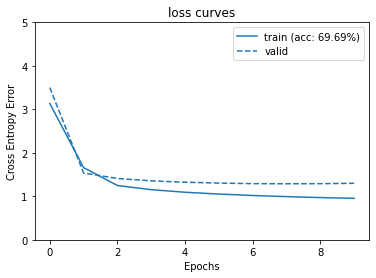

In [77]:
import matplotlib.pyplot as plt

plt.title("loss curves")

loss_train = np.array(loss_list)
loss_valid = np.mean(np.array(valid_loss_list), axis=1)


loss_curve, = plt.plot(loss_train, label=f'train (acc: {100 * float(accuracy_list[-1]):2.2f}%)')

plt.plot(loss_valid, linestyle='--', color=loss_curve.get_color(), label=f'valid')
plt.ylim(0, 5)  # you can change the upper limit if you want
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Error')
plt.legend();

Your figure caption here

<h2 style="color:rgb(0,120,170)">Excercise 5: Generate text</h2>

Now that you have a trained CharRNN, go on and generate some text. Therefore, start of with some initial text string you provide the model as the initial text and then predict character by character, always adding the previous predicted character to the input sequence for the next character.

**Bonus point:**
In practice, for this kind of task, you do not want to pick always the character with the highest probability, but instead pick randomly one of the top k classes/characters (with k e.g. 3 or 5). Adapt your text generation code to add this random sampling from the top k predictions to get a bonus point for this assignment. 

In [116]:

start_sentence = "I mean I've made so much money fighting against the Chinese "

top_k = 2
n_of_chars = 100

def softmax_pred(X):
    expo = torch.exp(X)
    expo_sum = torch.sum(torch.exp(X))
    soft = expo/expo_sum
    pred = torch.argmax(soft)
    if top_k > 1 and pred < 0.7:                 # < 0.7 condition for only doing randomization only in unsure cases for text quality
        vals, topk_idx = torch.topk(soft, top_k)
        idx = torch.randint(0, top_k, (1,))
        pred = topk_idx[0][idx]
    return pred

for i in range(n_of_chars):

    text_as_int = np.array([data.char2idx[c] for c in start_sentence.lower()])
    text_one_hot = nn.functional.one_hot(torch.tensor(text_as_int).type(torch.long), n_of_classes).type(torch.float)
    
    input_tensor = text_one_hot.reshape((1, text_one_hot.shape[0], text_one_hot.shape[1])).to(device)

    output = m.forward(input_tensor).detach()

    pred = softmax_pred(output.to(device))

    char = data.idx2char[pred]
    
    start_sentence += char

    print(start_sentence)


I mean I've made so much money fighting against the Chinese a
I mean I've made so much money fighting against the Chinese an
I mean I've made so much money fighting against the Chinese and
I mean I've made so much money fighting against the Chinese and 
I mean I've made so much money fighting against the Chinese and t
I mean I've made so much money fighting against the Chinese and th
I mean I've made so much money fighting against the Chinese and the
I mean I've made so much money fighting against the Chinese and the 
I mean I've made so much money fighting against the Chinese and the t
I mean I've made so much money fighting against the Chinese and the tr
I mean I've made so much money fighting against the Chinese and the tru
I mean I've made so much money fighting against the Chinese and the trum
I mean I've made so much money fighting against the Chinese and the trump
I mean I've made so much money fighting against the Chinese and the trump 
I mean I've made so much money fighting a